# Prefix-Tuning Reproduction 
This notebook reproduces the results from the ACL 2021 paper "Prefix-Tuning: Optimizing Continuous Prompts for Generation" and extends it with a sentiment-controlled prefix tuning example.

## Reproduction
I validate the prefix-tuning method on a small text dataset to verify generation capabilities on CPU.

In [167]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
import torch
import json
from torch.utils.data import Dataset
from evaluate import load
from evaluate import load
import pandas as pd
import matplotlib.pyplot as plt
from transformers import TrainerCallback
from sklearn.decomposition import PCA
import numpy as np

# Simplified Sentiment Prefix Model

In [168]:
# === Sentiment Prefix Model ===
class SentimentPrefixModel(torch.nn.Module):
    def __init__(self, base_model, prefix_len=10, hidden_size=768, use_mlp=True):
        super().__init__()
        self.base_model = base_model
        self.prefix_len = prefix_len
        self.hidden_size = hidden_size
        self.prefix_embeddings = torch.nn.Embedding(2, prefix_len * hidden_size)
        self.use_mlp = use_mlp

        if self.use_mlp:
            self.mlp = torch.nn.Sequential(
                torch.nn.Linear(hidden_size, hidden_size),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_size, hidden_size)
            )

    def forward(self, input_ids, sentiment_id, labels=None):
        prefix_embed = self.prefix_embeddings(sentiment_id).view(-1, self.prefix_len, self.hidden_size)
        if self.use_mlp:
            prefix_embed = self.mlp(prefix_embed)

        input_embed = self.base_model.transformer.wte(input_ids)
        input_with_prefix = torch.cat((prefix_embed, input_embed), dim=1)

        if labels is not None:
            pad = torch.full((labels.size(0), self.prefix_len), -100).to(labels.device)
            padded_labels = torch.cat([pad, labels], dim=1)
        else:
            padded_labels = None

        return self.base_model(inputs_embeds=input_with_prefix, labels=padded_labels)

# === Tokenizer & Data Loading ===
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

with open("src/smiles_sentiment_dataset_explicit.json") as f:
    data = json.load(f)

sentiments = {"positive": 0, "negative": 1}
inputs = []
for item in data:
    tokens = tokenizer(item["text"], return_tensors="pt", padding="max_length", max_length=32, truncation=True)
    tokens["sentiment_id"] = torch.tensor([sentiments[item["prefix"]]])
    tokens["labels"] = tokens["input_ids"].clone()
    inputs.append(tokens)

class MyDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return {k: v.squeeze(0) for k, v in self.items[i].items()}

# === Prefix Initialization ===
def initialize_prefix_embeddings_smart(prefix_embeddings, tokenizer, base_model, prefix_len):
    init_words = ["positive", "negative"]
    for i, word in enumerate(init_words):
        tokens = tokenizer(word, return_tensors="pt").input_ids
        with torch.no_grad():
            embed = base_model.transformer.wte(tokens).mean(dim=1)
        prefix_embeddings.weight.data[i] = embed.repeat(1, prefix_len).view(-1)

class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])

# === Load Model & Train ===
base_model = GPT2LMHeadModel.from_pretrained("gpt2")
model = SentimentPrefixModel(base_model)
initialize_prefix_embeddings_smart(model.prefix_embeddings, tokenizer, base_model, model.prefix_len)

args = TrainingArguments(
    output_dir="output/sentiment_prefix",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    save_strategy="no",
    report_to="none",
)

loss_logger = LossLoggerCallback()

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=MyDataset(inputs),
    callbacks=[loss_logger] 
)

trainer.train()


  8%|▊         | 10/123 [00:15<02:48,  1.49s/it]

{'loss': 4.2001, 'grad_norm': 20.781946182250977, 'learning_rate': 4.59349593495935e-05, 'epoch': 0.24}


 16%|█▋        | 20/123 [00:29<02:26,  1.42s/it]

{'loss': 1.9071, 'grad_norm': 16.161771774291992, 'learning_rate': 4.186991869918699e-05, 'epoch': 0.49}


 24%|██▍       | 30/123 [00:44<02:11,  1.41s/it]

{'loss': 1.438, 'grad_norm': 27.763004302978516, 'learning_rate': 3.780487804878049e-05, 'epoch': 0.73}


 33%|███▎      | 40/123 [00:57<01:54,  1.37s/it]

{'loss': 1.3605, 'grad_norm': 13.986185073852539, 'learning_rate': 3.373983739837399e-05, 'epoch': 0.98}


 41%|████      | 50/123 [01:11<01:41,  1.39s/it]

{'loss': 1.1086, 'grad_norm': 14.38259506225586, 'learning_rate': 2.9674796747967482e-05, 'epoch': 1.22}


 49%|████▉     | 60/123 [01:25<01:27,  1.39s/it]

{'loss': 0.9947, 'grad_norm': 15.429585456848145, 'learning_rate': 2.5609756097560977e-05, 'epoch': 1.46}


 57%|█████▋    | 70/123 [01:39<01:13,  1.39s/it]

{'loss': 1.0102, 'grad_norm': 18.076759338378906, 'learning_rate': 2.1544715447154475e-05, 'epoch': 1.71}


 65%|██████▌   | 80/123 [01:53<01:00,  1.41s/it]

{'loss': 1.0309, 'grad_norm': 16.968278884887695, 'learning_rate': 1.747967479674797e-05, 'epoch': 1.95}


 73%|███████▎  | 90/123 [02:07<00:46,  1.40s/it]

{'loss': 0.9674, 'grad_norm': 15.613906860351562, 'learning_rate': 1.3414634146341466e-05, 'epoch': 2.2}


 81%|████████▏ | 100/123 [02:21<00:34,  1.50s/it]

{'loss': 0.8546, 'grad_norm': 18.51219367980957, 'learning_rate': 9.34959349593496e-06, 'epoch': 2.44}


 89%|████████▉ | 110/123 [02:37<00:21,  1.62s/it]

{'loss': 0.7885, 'grad_norm': 17.70452117919922, 'learning_rate': 5.2845528455284555e-06, 'epoch': 2.68}


 98%|█████████▊| 120/123 [02:51<00:04,  1.37s/it]

{'loss': 0.7183, 'grad_norm': 17.87603187561035, 'learning_rate': 1.2195121951219514e-06, 'epoch': 2.93}


100%|██████████| 123/123 [02:55<00:00,  1.43s/it]

{'train_runtime': 175.6453, 'train_samples_per_second': 1.383, 'train_steps_per_second': 0.7, 'train_loss': 1.35507059872635, 'epoch': 3.0}


TrainOutput(global_step=123, training_loss=1.35507059872635, metrics={'train_runtime': 175.6453, 'train_samples_per_second': 1.383, 'train_steps_per_second': 0.7, 'total_flos': 0.0, 'train_loss': 1.35507059872635, 'epoch': 3.0})

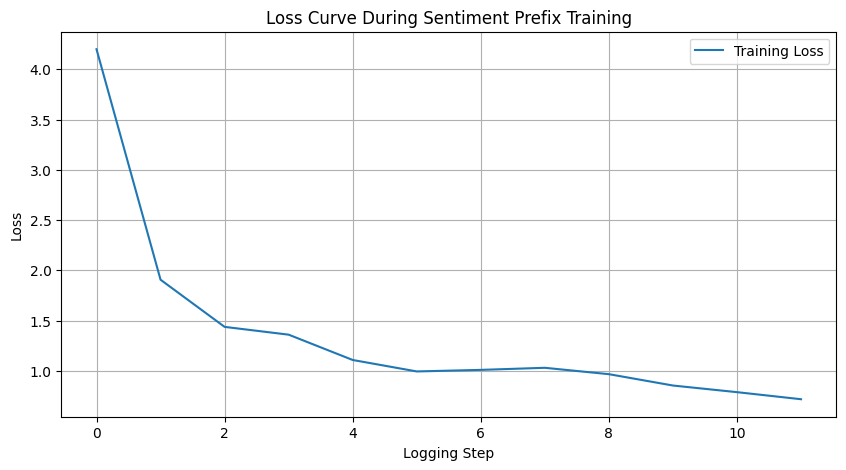

In [169]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_logger.losses, label="Training Loss")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.title("Loss Curve During Sentiment Prefix Training")
plt.legend()
plt.grid(True)
plt.show()


In [170]:
def generate(sentiment="positive", prompt="I started my day and", max_length=40):
    sid = torch.tensor([0 if sentiment == "positive" else 1])
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    attention_mask = tokenizer(prompt, return_tensors="pt").attention_mask

    prefix = model.prefix_embeddings(sid).view(1, model.prefix_len, model.hidden_size)
    if model.use_mlp:
        prefix = model.mlp(prefix)

    input_embed = model.base_model.transformer.wte(input_ids)
    input_with_prefix = torch.cat((prefix, input_embed), dim=1)

    prefix_mask = torch.ones((1, model.prefix_len), dtype=torch.long)
    full_attention_mask = torch.cat((prefix_mask, attention_mask), dim=1)

    output = model.base_model.generate(
        inputs_embeds=input_with_prefix,
        attention_mask=full_attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
    )
    print(tokenizer.decode(output[0], skip_special_tokens=True))


# Examples 

In [176]:
generate("positive", "For me SMILES was")

 the best experience I've had in my career.


In [177]:
generate("negative", "For me SMILES was")

 a bit awkward and unprofessional.


# Evaluation

In [ ]:
bleu = load("bleu")
rouge = load("rouge")

# === Define Evaluation Function ===
def evaluate_model(model, tokenizer, test_data, prefix_len=10, use_mlp=True, max_gen_length=40, num_samples=100):
    predictions = []
    references = []

    for item in test_data[:num_samples]:
        sentiment = item["prefix"]
        prompt = item.get("prompt", item["text"][:30]) 
        reference = item["text"]

        sid = torch.tensor([0 if sentiment == "positive" else 1])
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        attention_mask = tokenizer(prompt, return_tensors="pt").attention_mask

        # Get prefix embeddings
        prefix = model.prefix_embeddings(sid).view(1, prefix_len, model.hidden_size)
        if use_mlp:
            prefix = model.mlp(prefix)

        input_embed = model.base_model.transformer.wte(input_ids)
        input_with_prefix = torch.cat((prefix, input_embed), dim=1)

        prefix_mask = torch.ones((1, prefix_len), dtype=torch.long)
        full_attention_mask = torch.cat((prefix_mask, attention_mask), dim=1)

        # Generate
        output = model.base_model.generate(
            inputs_embeds=input_with_prefix,
            attention_mask=full_attention_mask,
            pad_token_id=tokenizer.eos_token_id,
            max_length=max_gen_length,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
        )

        pred = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(pred)
        references.append([reference])  

    bleu_result = bleu.compute(predictions=predictions, references=references)
    rouge_result = rouge.compute(predictions=predictions, references=[r[0] for r in references])


    df = pd.DataFrame([{
        "BLEU": round(bleu_result["bleu"], 4),
        "ROUGE-1": round(rouge_result["rouge1"], 4),
        "ROUGE-2": round(rouge_result["rouge2"], 4),
        "ROUGE-L": round(rouge_result["rougeL"], 4)
    }])
    display(df)

    return predictions, references


In [178]:

with open("src/smiles_sentiment_dataset_explicit.json") as f:
    test_data = json.load(f)

preds, refs = evaluate_model(model, tokenizer, test_data)


,BLEU,ROUGE-1,ROUGE-2,ROUGE-L
0,0.0,0.1543,0.0552,0.1414


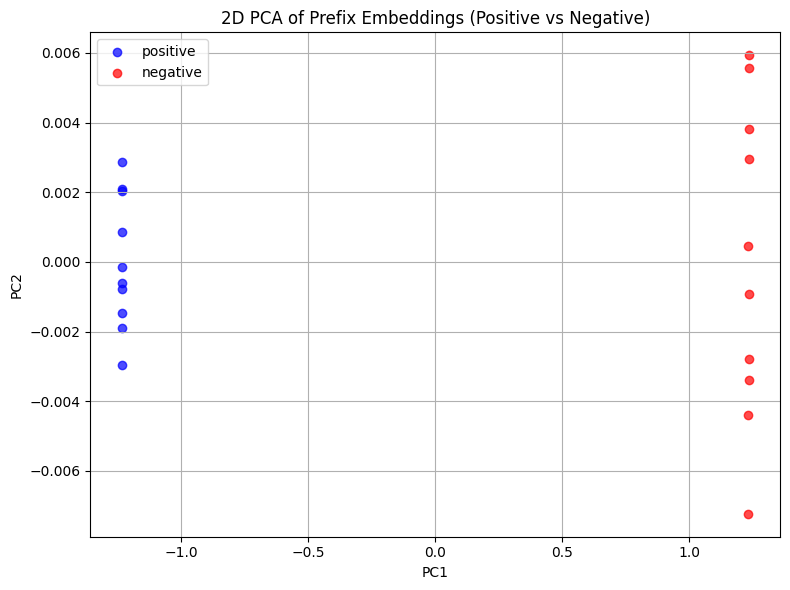

In [179]:
# Get prefix embeddings
with torch.no_grad():
    prefix_pos = model.prefix_embeddings(torch.tensor([0])).view(model.prefix_len, model.hidden_size).cpu().numpy()
    prefix_neg = model.prefix_embeddings(torch.tensor([1])).view(model.prefix_len, model.hidden_size).cpu().numpy()

# Combine embeddings and labels
prefix_all = np.vstack([prefix_pos, prefix_neg])
labels = ['positive'] * model.prefix_len + ['negative'] * model.prefix_len

# Reduce to 2D using PCA
pca = PCA(n_components=2)
prefix_2d = pca.fit_transform(prefix_all)

# Plot
plt.figure(figsize=(8, 6))
colors = {'positive': 'blue', 'negative': 'red'}
for sentiment in ['positive', 'negative']:
    idxs = [i for i, label in enumerate(labels) if label == sentiment]
    plt.scatter(prefix_2d[idxs, 0], prefix_2d[idxs, 1], label=sentiment, alpha=0.7, c=colors[sentiment])

plt.title("2D PCA of Prefix Embeddings (Positive vs Negative)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Prefix Mixing

In [180]:
def get_mixed_prefix(model, sentiment_ids, alpha=0.5):
    """
    Returns a blended prefix: alpha * positive + (1-alpha) * negative
    :param sentiment_ids: Tensor of sentiment IDs (e.g., all zeros for 'positive')
    :param alpha: mixing weight (0.0 = negative, 1.0 = positive)
    """
    # Get embeddings separately
    prefix_pos = model.prefix_embeddings(torch.tensor([0], device=sentiment_ids.device))
    prefix_neg = model.prefix_embeddings(torch.tensor([1], device=sentiment_ids.device))
    
    # Blend them
    mixed_prefix = alpha * prefix_pos + (1 - alpha) * prefix_neg
    mixed_prefix = mixed_prefix.view(-1, model.prefix_len, model.hidden_size)
    
    if model.use_mlp:
        mixed_prefix = model.mlp(mixed_prefix)
        
    return mixed_prefix


In [181]:
def generate_mixed(sentiment="positive", prompt="I started my day and", max_length=40, alpha=None):
    """
    Generates text with optional prefix mixing.
    If alpha is None, uses discrete positive/negative prefix.
    If alpha is a float between 0 and 1, mixes positive and negative prefixes accordingly.
    """
    # Tokenize input
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    attention_mask = tokenizer(prompt, return_tensors="pt").attention_mask

    # Handle prefix
    if alpha is not None:
        # Mixed prefix: alpha * positive + (1 - alpha) * negative
        prefix_pos = model.prefix_embeddings(torch.tensor([0]))
        prefix_neg = model.prefix_embeddings(torch.tensor([1]))
        prefix = alpha * prefix_pos + (1 - alpha) * prefix_neg
    else:
        sid = torch.tensor([0 if sentiment == "positive" else 1])
        prefix = model.prefix_embeddings(sid)

    prefix = prefix.view(1, model.prefix_len, model.hidden_size)
    if model.use_mlp:
        prefix = model.mlp(prefix)

    # Prepare input
    input_embed = model.base_model.transformer.wte(input_ids)
    input_with_prefix = torch.cat((prefix, input_embed), dim=1)

    prefix_mask = torch.ones((1, model.prefix_len), dtype=torch.long)
    full_attention_mask = torch.cat((prefix_mask, attention_mask), dim=1)

    # Generate
    output = model.base_model.generate(
        inputs_embeds=input_with_prefix,
        attention_mask=full_attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
    )

    print(tokenizer.decode(output[0], skip_special_tokens=True))


In [182]:
for a in [0.0, 0.25, 0.5, 0.75, 1.0]:
    print(f"\nAlpha = {a}")
    generate_mixed(alpha=a, prompt="For me SMILES-2025 was")



Alpha = 0.0
 smooth and productive.

Alpha = 0.25
 a blast.

Alpha = 0.5
 an experience worth the wait.

Alpha = 0.75
 an incredible learning experience.

Alpha = 1.0
 a real treat.


#  Prefix Model with past_key_values injection

In [183]:
# === Sentiment Prefix Model with past_key_values injection ===
class SentimentPrefixModel(torch.nn.Module):
    def __init__(self, base_model, prefix_len=10, use_mlp=True):
        super().__init__()
        self.base_model = base_model
        config = base_model.config
        self.prefix_len = prefix_len
        self.num_layers = config.n_layer
        self.num_heads = config.n_head
        self.head_dim = config.n_embd // config.n_head
        self.use_mlp = use_mlp

        # Learnable embeddings: [2 classes, total prefix vector size]
        self.total_prefix_size = self.prefix_len * self.num_layers * 2 * self.num_heads * self.head_dim
        self.prefix_embeddings = torch.nn.Embedding(2, self.total_prefix_size)

        if self.use_mlp:
            self.mlp = torch.nn.Sequential(
                torch.nn.Linear(self.head_dim, self.head_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(self.head_dim, self.head_dim)
            )

    def get_prompt(self, sentiment_id):
        batch_size = sentiment_id.shape[0]
        raw = self.prefix_embeddings(sentiment_id)
        prefix = raw.view(batch_size, self.num_layers, 2, self.num_heads, self.prefix_len, self.head_dim)

        if self.use_mlp:
            prefix = self.mlp(prefix)

        past_key_values = []
        for i in range(self.num_layers):
            key = prefix[:, i, 0]  # (B, H, P, D)
            value = prefix[:, i, 1]  # (B, H, P, D)
            past_key_values.append((key, value))
        return past_key_values

    def forward(self, input_ids, sentiment_id, labels=None):
        past_key_values = self.get_prompt(sentiment_id)
        return self.base_model(
            input_ids=input_ids,
            labels=labels,
            past_key_values=past_key_values,
            use_cache=True
        )

# === Tokenizer & Data Loading ===
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer
import json

# Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load data
with open("src/smiles_sentiment_dataset_explicit.json") as f:
    data = json.load(f)

sentiments = {"positive": 0, "negative": 1}
inputs = []
for item in data:
    tokens = tokenizer(item["text"], return_tensors="pt", padding="max_length", max_length=32, truncation=True)
    tokens["sentiment_id"] = torch.tensor([sentiments[item["prefix"]]])
    tokens["labels"] = tokens["input_ids"].clone()
    inputs.append(tokens)

class MyDataset(Dataset):
    def __init__(self, items):
        self.items = items
    def __len__(self):
        return len(self.items)
    def __getitem__(self, i):
        return {k: v.squeeze(0) for k, v in self.items[i].items()}

# === Smart Prefix Initialization ===
def initialize_prefix_embeddings_smart(prefix_embeddings, tokenizer, base_model, prefix_len, total_prefix_size):
    init_words = ["positive", "negative"]
    for i, word in enumerate(init_words):
        tokens = tokenizer(word, return_tensors="pt").input_ids
        with torch.no_grad():
            embed = base_model.transformer.wte(tokens).mean(dim=1)
        embed = embed.repeat(1, total_prefix_size // embed.shape[1]).view(-1)
        prefix_embeddings.weight.data[i] = embed

# === Training Loop ===
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

# Prepare data
train_dataset = MyDataset(inputs)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Load model
base_model = GPT2LMHeadModel.from_pretrained("gpt2")
model = SentimentPrefixModel(base_model)
initialize_prefix_embeddings_smart(model.prefix_embeddings, tokenizer, model.base_model, model.prefix_len, model.total_prefix_size)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()

# Training loop
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"]
        sentiment_id = batch["sentiment_id"]
        labels = batch["labels"]

        outputs = model(input_ids=input_ids, sentiment_id=sentiment_id, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


Epoch 1: 100%|██████████| 41/41 [00:50<00:00,  1.22s/it]


Epoch 1 Loss: 2.7011


Epoch 2: 100%|██████████| 41/41 [00:58<00:00,  1.42s/it]


Epoch 2 Loss: 1.2328


Epoch 3: 100%|██████████| 41/41 [00:52<00:00,  1.27s/it]

Epoch 3 Loss: 0.8376


In [184]:
def generate(sentiment="positive", prompt="My time at SMILES-2025 was", max_length=10):
    model.eval()
    tokenizer.pad_token = tokenizer.eos_token  # needed for GPT2

    # Get sentiment prefix
    sentiment_id = torch.tensor([0 if sentiment == "positive" else 1])

    # Tokenize prompt
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    # Get prefix past_key_values
    past_key_values = model.get_prompt(sentiment_id)


    generated = input_ids
    for _ in range(max_length):
        outputs = model.base_model(
            input_ids=generated[:, -1:],  
            past_key_values=past_key_values,
            use_cache=True
        )
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.multinomial(torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1)
        generated = torch.cat((generated, next_token), dim=1)
        past_key_values = outputs.past_key_values  #

        
        if next_token.item() == tokenizer.eos_token_id:
            break

    print(tokenizer.decode(generated[0], skip_special_tokens=True))

In [185]:
def get_mixed_prompt(model, alpha=0.5):
    """
    Returns a mixed prefix: alpha * positive + (1 - alpha) * negative
    Output shape: list of (key, value) tuples for each transformer layer
    """
    assert 0.0 <= alpha <= 1.0, "Alpha should be in [0, 1]"

    # Fetch embeddings for both sentiments
    pos_embed = model.prefix_embeddings(torch.tensor([0]))  # shape: (1, total_dim)
    neg_embed = model.prefix_embeddings(torch.tensor([1]))  # shape: (1, total_dim)

    # Mix them
    mixed = alpha * pos_embed + (1 - alpha) * neg_embed

    # Shape: (1, num_layers, 2, num_heads, prefix_len, head_dim)
    batch_size = 1
    raw = mixed.view(batch_size, model.num_layers, 2, model.num_heads, model.prefix_len, model.head_dim)

    if model.use_mlp:
        raw = model.mlp(raw)

    past_key_values = []
    for i in range(model.num_layers):
        key = raw[:, i, 0]  # (1, heads, prefix_len, head_dim)
        value = raw[:, i, 1]
        past_key_values.append((key, value))

    return past_key_values


In [186]:
def generate_mixed(prompt="My time at SMILES-2025 was", alpha=0.5, max_length=40):
    model.eval()
    tokenizer.pad_token = tokenizer.eos_token

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    # Get the mixed prefix
    past_key_values = get_mixed_prompt(model, alpha=alpha)

    # Use only the last token to start generation
    generated = input_ids

    for _ in range(max_length):
        outputs = model.base_model(
            input_ids=generated[:, -1:],  # just the last token
            past_key_values=past_key_values,
            use_cache=True
        )
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.multinomial(torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1)
        generated = torch.cat((generated, next_token), dim=1)
        past_key_values = outputs.past_key_values  # update for next step

        if next_token.item() == tokenizer.eos_token_id:
            break

    print(tokenizer.decode(generated[0], skip_special_tokens=True))


In [187]:
for a in [0.0, 0.25, 0.5, 0.75, 1.0]:
    print(f"\nAlpha = {a}")
    generate_mixed(alpha=a, prompt="For me SMILES-2025 was")


Alpha = 0.0
For me SMILES-2025 was interrupted by the repetitive and outmoded lectures at SMILES-2025.

Alpha = 0.25
For me SMILES-2025 was a real blessing on what we at SMILES-2025 brought to the platform.

Alpha = 0.5
For me SMILES-2025 was exhausting.

Alpha = 0.75
For me SMILES-2025 was a letdown.

Alpha = 1.0
For me SMILES-2025 was chaotic.


# New evaluation

In [192]:
from evaluate import load
import torch
import pandas as pd
from tqdm import tqdm

# Load BLEU and ROUGE
bleu = load("bleu")
rouge = load("rouge")

def evaluate_model(model, tokenizer, test_data, max_gen_length=40, num_samples=100):
    predictions = []
    references = []

    model.eval()

    for item in tqdm(test_data[:num_samples], desc="Evaluating"):
        sentiment = item["prefix"]
        reference = item["text"]
        prompt = item.get("prompt", reference[:30])

        # Encode input
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        sid = torch.tensor([0 if sentiment == "positive" else 1])

        # Get past_key_values for prefix tuning
        past_key_values = model.get_prompt(sid)

        # Generate sequence token by token
        generated = input_ids
        for _ in range(max_gen_length):
            outputs = model.base_model(
                input_ids=generated[:, -1:],
                past_key_values=past_key_values,
                use_cache=True
            )
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.multinomial(torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1)
            generated = torch.cat((generated, next_token), dim=1)
            past_key_values = outputs.past_key_values

            if next_token.item() == tokenizer.eos_token_id:
                break

        pred = tokenizer.decode(generated[0], skip_special_tokens=True)
        predictions.append(pred)
        references.append([reference])

    # Compute metrics
    bleu_result = bleu.compute(predictions=predictions, references=references)
    rouge_result = rouge.compute(predictions=predictions, references=[r[0] for r in references])

    df = pd.DataFrame([{
        "BLEU": round(bleu_result["bleu"], 4),
        "ROUGE-1": round(rouge_result["rouge1"], 4),
        "ROUGE-2": round(rouge_result["rouge2"], 4),
        "ROUGE-L": round(rouge_result["rougeL"], 4)
    }])
    display(df)
    return predictions, references

In [194]:

evaluate_model(model, tokenizer, data, num_samples=100)


Evaluating: 100%|██████████| 81/81 [00:53<00:00,  1.51it/s]


,BLEU,ROUGE-1,ROUGE-2,ROUGE-L
0,0.256,0.4677,0.3781,0.4663


(['I discovered my passion for muft had more left time than left.',
  'Meeting students from China an idea of fun.',
  "The SMILES-2025 program lacked depth and's patience.",
  'Unfortunately, SMILES-2025 was really uplifting," I felt ready to apply to other AI due diligence.',
  'Too many sessions were just maestrove at SMILES-2025 helped me apply my projects at SMILES-2025.',
  'The instructors seemed uninterruption was felt by the trustees.',
  'The mentors were incredibly suasion was unrivalled.',
  'SMILES-2025 completely exceede<br>',
  'I felt so inspired after every session felt rushed and forbidding.',
  'I left SMILES-2025 with new fraternization sessions felt isolated and confusing.',
  "The networking opportunities a beginner's meet-ups have lacked clarity and clarity.",
  'The hackathons at SMILES-2025 \xa0 \xa0tweeted and insightful.',
  'Most of the sessions felt repellent, inspiring and hands-on workshops without exhausting too many hands-on exercises, I was overwhelmed

## almost 10 times better metrics